Analyzing data with PAAT
========

In [1]:
%%capture
import os
import h5py
import paat
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 3]
plt.rcParams['font.size'] = '13'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Load data from GT3X file
------------------------

To load data from a gt3x file, the `paat.io.read_gt3x` function is implemented in
the `paat.io` module. However, you can also call the function directly from the top-level:

In [2]:
data, sample_freq = paat.read_gt3x("data/nwt_recording.gt3x")

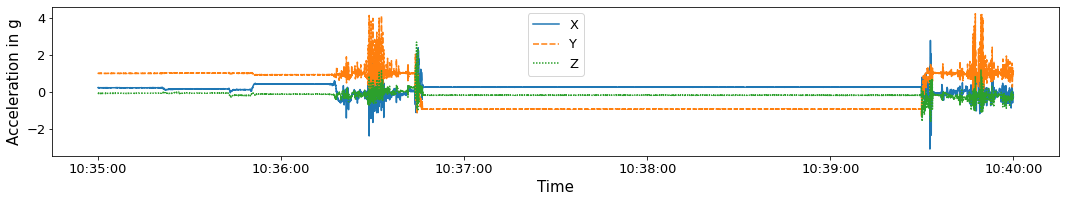

In [3]:
%%capture --no-display
ax = sns.lineplot(data=data[['X', 'Y', 'Z']], legend=True)

labels = [(data.index[0] + pd.to_timedelta(minutes, unit='m')).strftime("%H:%M:%S") for minutes in range(len(ax.get_xticks()))]
ax.set_xticklabels(labels)   

# Set axes labels
ax.set_xlabel("Time", size=15)
ax.set_ylabel("Acceleration in g", size=15)

plt.tight_layout()
print('')

Detect non-wear periods
-----------------------

Different methods to infer non-wear time from the raw acceleration signal are
implemented in the `paat.wear_time` module. We suggest to use
`paat.wear_time.detect_non_wear_time_syed2021` published by [Syed et al. (2021)](https://doi.org/10.1038/s41598-021-87757-z) as this algorithm demonstrated the most accurate estimates for hip-worn ActiGraph acceleration. This function can also be called from the top-level:

In [4]:
data.loc[:, "Non Wear Time"] = paat.detect_non_wear_time_syed2021(data, sample_freq)

But there are also other non-wear time algorithm implemented in the `paat.wear_time`
module. For wrist-worn accelerometer data, the method developed by [Hees et al (2011)](https://doi.org/10.1371/journal.pone.0022922) might be more
appropriate and is implemented in `paat.wear_time.detect_non_wear_time_hees2011` or can be called directly:

In [5]:
data.loc[:, "Non Wear Time Hees"] = paat.detect_non_wear_time_hees2011(data, sample_freq)